# The Milwaukee Journal Sentinel and Life Expectancy

**Story:** [Race gap found in pothole patching](https://web.archive.org/web/20081223094123/http://www.jsonline.com/news/milwaukee/32580034.html)

**Author:** Keegan Kyle, Grant Smith and Ben Poston, Milwaukee Journal Sentinel

**Topics:** Census Data, Geocoding, QGIS Spatial Joins, Linear Regression

**Datasets**

* Pothole fill data from the Milwaukee [Department of Public Works](https://city.milwaukee.gov/dpw)
    - **2007-2010 POTHOLES.xls**: Pothole data, July 2007-July 2010
    - **2010-2013 POTHOLES.xls**: Pothole data, July 2010-July 2013
    - **2013-2017 POTHOLES.xls**: Pothole data, July 2013-July 2017
* **tl_2013_55_tract.zip:** 2013 census tract boundaries from the [US Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
* **addresses_geocoded.csv:** a large selection of addresses in Milwaukee, geocoded by [Geocod.io](https://geocod.io)
* **R12216099_SL140.csv:** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A04001, Hispanic or Latino by Race
    - `R12216099.txt` is the data dictionary
* **R12216226_SL140.csv** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A14006, 2013 Median Household income
    - Data dictionary [is here](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A14006)

# What's the story?

We're trying to figure out if the **time it took Milwaukee to fill pot holes** is related to the racial makeup of a census tract.

# Do your imports

You'll also want to set pandas to display **up to 200 columns at a time**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
pd.options.display.max_columns = 200
# pd.reset_option('display.max_columns')

# Create a dataframe of potholes from only 2013

The delivered multiple files to us, so we'll need to filter them down to just 2013.

**Editorial decision:** When we say "a pothole from 2013," what exactly do we mean?

In [3]:
df1pt = pd.read_excel('sources/2010-2013 POTHOLES.xls')
df2pt = pd.read_excel('sources/2013-2017 POTHOLES.xls')
print(df1pt.shape , df2pt.shape)

(33644, 5) (48429, 5)


In [4]:
ph13_df = pd.concat([df2pt, df1pt])
ph13_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82073 entries, 0 to 33643
Data columns (total 5 columns):
A           82073 non-null int64
Street      82073 non-null object
EnterDt     82073 non-null object
PrintDt     74464 non-null object
ResolvDt    82037 non-null object
dtypes: int64(1), object(4)
memory usage: 2.5+ MB


In [5]:
ph13_df.head()

,A,Street,EnterDt,PrintDt,ResolvDt
0,7741,N 59TH ST,2017-07-15 08:55,2017-07-17 05:33,2017-07-21 04:51
1,5517,N 39TH ST,2017-07-14 22:36,2017-07-17 05:33,2017-07-25 15:29
2,8242,N GRANVILLE RD,2017-07-14 18:30,2017-07-17 05:33,2017-07-17 06:55
3,3364,W LAKEFIELD DR,2017-07-14 16:35,2017-07-17 05:22,2017-07-18 05:47
4,10700,W GOOD HOPE RD,2017-07-14 15:18,2017-07-17 05:33,2017-07-21 04:58


In [6]:
ph13_df = ph13_df[ph13_df.EnterDt.str.contains('2013')]
ph13_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 45026 to 9432
Data columns (total 5 columns):
A           12836 non-null int64
Street      12836 non-null object
EnterDt     12836 non-null object
PrintDt     11907 non-null object
ResolvDt    12828 non-null object
dtypes: int64(1), object(4)
memory usage: 401.1+ KB


In [7]:
ph13_df.head()

,A,Street,EnterDt,PrintDt,ResolvDt
45026,2902,N 51ST ST,2013-12-31 17:06,2014-01-02 06:06,2014-01-02 14:25
45027,2939,N 20TH ST,2013-12-31 17:06,2014-01-02 06:06,2014-01-02 14:26
45028,2634,N 20TH ST,2013-12-31 17:06,2014-01-02 06:06,2014-01-02 14:26
45029,2838,N 20TH ST,2013-12-31 17:06,2014-01-02 06:06,2014-01-02 14:26
45030,2535,N 20TH ST,2013-12-31 17:05,2014-01-02 06:06,2014-01-02 14:27


## What is the maximum and minimum `EnterDt` and `ResolvDt`?

Use this to confirm that your date range is what you expected. If it isn't, take a look at what might have happened with your dataset.

* **Tip:** Missing data might be a headache

In [8]:
ph13_df.agg({'EnterDt':['min','max']})

,EnterDt
min,2013-01-02 06:31
max,2013-12-31 17:06


In [9]:
ph13_df.dropna().agg({'ResolvDt':['min','max']})

,ResolvDt
min,2013-01-02 06:33
max,2014-01-23 17:05


## Calculate how long it took to fill potholes in 2013

Save it into a new column.

* **Tip:** It's possible to subtract two dates

In [10]:
forceDT = ['EnterDt','PrintDt','ResolvDt']
ph13_df[forceDT] = ph13_df[forceDT].apply(pd.to_datetime)

In [11]:
ph13_df['ResTime'] = ph13_df.ResolvDt - ph13_df.EnterDt
ph13_df.ResTime.head()

45026   1 days 21:19:00
45027   1 days 21:20:00
45028   1 days 21:20:00
45029   1 days 21:20:00
45030   1 days 21:22:00
Name: ResTime, dtype: timedelta64[ns]

### Hrm, well, I think we need that difference to be an integer

If your new column isn't an integer, create _another_ column that is.

* **Tip:** Just like you might use `.str.strip()` on a string column, if your column is a datetime you can use `.dt.components` to get the days, hours, minutes, seconds, etc of the column.

In [12]:
ph13_df['ResDays'] = ph13_df.ResTime.dt.components.days
ph13_df.ResDays = ph13_df.ResDays.fillna(0).astype(int)

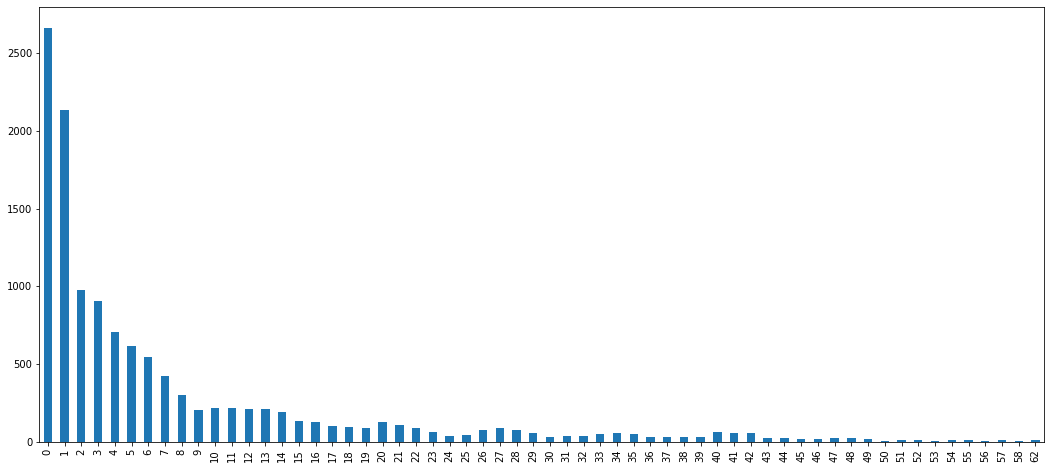

In [13]:
ph13_df.ResDays.value_counts().head(60).sort_index().plot(kind='bar',figsize=(18,8))

# Read in your race-related census data

* **Tip:** This will probably give you an error the first time you try, because the Census Bureau doesn't think about the rest of the world.

In [14]:
tractPopRaw_df = pd.read_csv("sources/R12216099_SL140.csv", encoding='latin-1')

In [15]:
tractInc_df = pd.read_csv("sources/R12216226_SL140.csv", encoding='latin-1', usecols=['Geo_TRACT','SE_A14006_001'])
tractPopRaw_df = tractPopRaw_df.merge(tractInc_df, on='Geo_TRACT')

In [16]:
tractPopRaw_df.rename(columns={'Geo_FIPS':'FIPS',
                         'Geo_GEOID':'GeoID',
                         'Geo_NAME':'Name',
                         'Geo_LOGRECNO':'LogRecNum',
                         'Geo_TRACT':'Tract',
                         'SE_A04001_001':'Pop',
                         'SE_A04001_002':'Pop_NonHis_All',
                         'SE_A04001_003':'Pop_NonHis_White',
                         'SE_A04001_004':'Pop_NonHis_Black',
                         'SE_A04001_005':'Pop_NonHis_NA',
                         'SE_A04001_006':'Pop_NonHis_Asian',
                         'SE_A04001_007':'Pop_NonHis_PI',
                         'SE_A04001_008':'Pop_NonHis_Other',
                         'SE_A04001_009':'Pop_NonHis_Multi',
                         'SE_A04001_010':'Pop_His_All',
                         'SE_A04001_011':'Pop_His_White',
                         'SE_A04001_012':'Pop_His_Black',
                         'SE_A04001_013':'Pop_His_NA',
                         'SE_A04001_014':'Pop_His_Asian',
                         'SE_A04001_015':'Pop_His_PI',
                         'SE_A04001_016':'Pop_His_Other',
                         'SE_A04001_017':'Pop_His_Multi',
                         'SE_A14006_001':'Med_Income'
                         }, inplace=True)
tractPopRaw_df.dropna(how='all', axis=1, inplace=True)
tractPopRaw_df.drop(['Geo_QName','Geo_STUSAB','Geo_SUMLEV','Geo_GEOCOMP','Geo_FILEID','Geo_STATE','Geo_COUNTY'], axis=1, inplace=True)
tractPopRaw_df.Med_Income = tractPopRaw_df.Med_Income.fillna(0).astype(int)

In [17]:
tractPopRaw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 297
Data columns (total 23 columns):
FIPS                298 non-null int64
GeoID               298 non-null object
Name                298 non-null object
LogRecNum           298 non-null int64
Tract               298 non-null int64
Pop                 298 non-null int64
Pop_NonHis_All      298 non-null int64
Pop_NonHis_White    298 non-null int64
Pop_NonHis_Black    298 non-null int64
Pop_NonHis_NA       298 non-null int64
Pop_NonHis_Asian    298 non-null int64
Pop_NonHis_PI       298 non-null int64
Pop_NonHis_Other    298 non-null int64
Pop_NonHis_Multi    298 non-null int64
Pop_His_All         298 non-null int64
Pop_His_White       298 non-null int64
Pop_His_Black       298 non-null int64
Pop_His_NA          298 non-null int64
Pop_His_Asian       298 non-null int64
Pop_His_PI          298 non-null int64
Pop_His_Other       298 non-null int64
Pop_His_Multi       298 non-null int64
Med_Income          298 non-null in

In [18]:
tractPopRaw_df.head()

,FIPS,GeoID,Name,LogRecNum,Tract,Pop,Pop_NonHis_All,Pop_NonHis_White,Pop_NonHis_Black,Pop_NonHis_NA,Pop_NonHis_Asian,Pop_NonHis_PI,Pop_NonHis_Other,Pop_NonHis_Multi,Pop_His_All,Pop_His_White,Pop_His_Black,Pop_His_NA,Pop_His_Asian,Pop_His_PI,Pop_His_Other,Pop_His_Multi,Med_Income
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin",4717,101,5306,5015,1343,3567,13,70,0,16,6,291,37,0,0,0,0,254,0,27421
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin",4718,102,3648,3549,1034,2195,36,118,0,0,166,99,67,32,0,0,0,0,0,40692
2,55079000201,14000US55079000201,"Census Tract 2.01, Milwaukee County, Wisconsin",4719,201,4791,4019,1185,2657,0,102,0,0,75,772,120,0,0,0,0,613,39,26699
3,55079000202,14000US55079000202,"Census Tract 2.02, Milwaukee County, Wisconsin",4720,202,6324,6148,2687,2810,87,390,12,0,162,176,113,0,0,0,0,63,0,60294
4,55079000301,14000US55079000301,"Census Tract 3.01, Milwaukee County, Wisconsin",4721,301,1339,1339,1005,220,0,90,0,10,14,0,0,0,0,0,0,0,0,65000


## Create new dataframe describing the racial makeup of each census tract

Each row should contain:

* The census tract number
* The percent of the population that is White
* The percent of the population that is Black
* The percent of the population that is Hispanic
* The percent of the population that is a minority (non-White)

You can either calculate and filter on the original shapefile, or create a whole new dataframe.

* **Tip:** You'll want to read the data dictionary for the Census data.
* **Tip:** The column names don't exactly match the data dictionary, but you can figure it out
* **Tip:** If you aren't sure which column is the actual census tract number, you can keep multiples for now

In [19]:
tractPop_df = tractPopRaw_df[['Tract','Med_Income','Pop',]]
tractPop_df['Pop_pcWhite'] = (tractPopRaw_df.Pop_NonHis_White + tractPopRaw_df.Pop_His_White) / tractPopRaw_df.Pop
tractPop_df['Pop_pcBlack'] = (tractPopRaw_df.Pop_NonHis_Black + tractPopRaw_df.Pop_His_Black) / tractPopRaw_df.Pop
tractPop_df['Pop_pcHispanic'] = tractPopRaw_df.Pop_His_All / tractPopRaw_df.Pop
tractPop_df['Pop_pcMinority'] = (tractPopRaw_df.Pop - tractPopRaw_df.Pop_NonHis_White) / tractPopRaw_df.Pop
tractPop_df

C:\Program Files (x86)\Python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files (x86)\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files (x86)\Python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,Tract,Med_Income,Pop,Pop_pcWhite,Pop_pcBlack,Pop_pcHispanic,Pop_pcMinority
0,101,27421,5306,0.260083,0.672258,0.054844,0.746890
1,102,40692,3648,0.301809,0.610471,0.027138,0.716557
2,201,26699,4791,0.272386,0.554582,0.161135,0.752661
3,202,60294,6324,0.442758,0.444339,0.027830,0.575111
4,301,65000,1339,0.750560,0.164302,0.000000,0.249440
5,302,39408,3091,0.168877,0.772566,0.046910,0.855063
6,303,38590,2029,0.438147,0.463775,0.024150,0.574174
7,304,76152,3072,0.440755,0.371094,0.015625,0.570964
8,400,29943,2450,0.248980,0.564898,0.034694,0.751020
9,501,42321,3539,0.458039,0.405764,0.053970,0.554676


# Combine this census data with your street address data

Create a new dataframe my merging your street addresses with your census data. It would be nice to marge on census tract code, but your addresses data does **not** have a census tract on them! **This is where things get a little crazy.**

### Adding census tract codes to addresses

We went ahead and geocoded many addresses in Milwaukee to create `addresses_geocoded.csv`. You'll need to add a new column using QGIS that adds in the address's census tract.

The QGIS command **Join attributes by location** will merge datasets that geographically overlap each other. If you have one layer that's a list of lat/lon points and one layer that's a shapefile with census tract information, **join attributes by location** can create a new layer of lat/lon points that also has census tract information.

You can export the result by right clicking the layer, selecting **Export As** and making sure the output is another CSV.

### Merging

Now you'll have three datasets:

* Addresses and pothole fill ties
* Census data according with census tract codes
* Addresses with census tract codes

You'll need to merge them each together to create one whole dataset.

In [20]:
ph13_df.head()

,A,Street,EnterDt,PrintDt,ResolvDt,ResTime,ResDays
45026,2902,N 51ST ST,2013-12-31 17:06:00,2014-01-02 06:06:00,2014-01-02 14:25:00,1 days 21:19:00,1
45027,2939,N 20TH ST,2013-12-31 17:06:00,2014-01-02 06:06:00,2014-01-02 14:26:00,1 days 21:20:00,1
45028,2634,N 20TH ST,2013-12-31 17:06:00,2014-01-02 06:06:00,2014-01-02 14:26:00,1 days 21:20:00,1
45029,2838,N 20TH ST,2013-12-31 17:06:00,2014-01-02 06:06:00,2014-01-02 14:26:00,1 days 21:20:00,1
45030,2535,N 20TH ST,2013-12-31 17:05:00,2014-01-02 06:06:00,2014-01-02 14:27:00,1 days 21:22:00,1


In [21]:
tractGeo_df = pd.read_csv("sources/addresses_geocoded_wTract.csv", usecols=['Number','Street','Latitude','Longitude','TRACTCE'])

In [22]:
tractGeo_df = tractGeo_df.dropna(subset=['Number','Street'])
tractGeo_df.Number = tractGeo_df.Number.astype(int)
tractGeo_df.Street = tractGeo_df.Street.str.upper()

In [40]:
tractGeo_df.head()

,Latitude,Longitude,Number,Street,TRACTCE
0,43.177901,-88.063649,8900,N 124TH ST,200202
1,43.056711,-87.880801,2200,N TERRACE AVE,186900
2,43.043277,-87.898690,1000,N PROSPECT AVE,186900
3,43.052106,-87.890486,1700,N PROSPECT AVE,186900
4,43.059308,-87.879216,2298,N TERRACE AVE,186900


In [41]:
ph13full_df = ph13_df.merge(tractGeo_df, how='left', left_on=['A','Street'], right_on=['Number','Street'])
del ph13full_df['Number']
ph13full_df.rename(columns={'A':'Number','TRACTCE':'Tract'}, inplace=True)

In [42]:
print(ph13_df.shape , tractGeo_df.shape , ph13full_df.shape)

(12836, 7) (53091, 5) (12902, 10)


In [43]:
ph13full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12902 entries, 0 to 12901
Data columns (total 10 columns):
Number       12902 non-null int64
Street       12902 non-null object
EnterDt      12902 non-null datetime64[ns]
PrintDt      11970 non-null datetime64[ns]
ResolvDt     12894 non-null datetime64[ns]
ResTime      12894 non-null timedelta64[ns]
ResDays      12902 non-null int32
Latitude     8709 non-null float64
Longitude    8709 non-null float64
Tract        8709 non-null float64
dtypes: datetime64[ns](3), float64(3), int32(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 1008.0+ KB


In [44]:
ph13full_df = ph13full_df.merge(tractPop_df, how='left', on='Tract')

In [45]:
ph13full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12902 entries, 0 to 12901
Data columns (total 16 columns):
Number            12902 non-null int64
Street            12902 non-null object
EnterDt           12902 non-null datetime64[ns]
PrintDt           11970 non-null datetime64[ns]
ResolvDt          12894 non-null datetime64[ns]
ResTime           12894 non-null timedelta64[ns]
ResDays           12902 non-null int32
Latitude          8709 non-null float64
Longitude         8709 non-null float64
Tract             8709 non-null float64
Med_Income        8707 non-null float64
Pop               8707 non-null float64
Pop_pcWhite       8692 non-null float64
Pop_pcBlack       8692 non-null float64
Pop_pcHispanic    8692 non-null float64
Pop_pcMinority    8692 non-null float64
dtypes: datetime64[ns](3), float64(9), int32(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 1.6+ MB


##  <span style="color:red"> 🢁 That seems like a lot of data loss on some bad joins 🢁 </span>

In [58]:
ph13full_df = ph13full_df.dropna(subset=['Pop'])

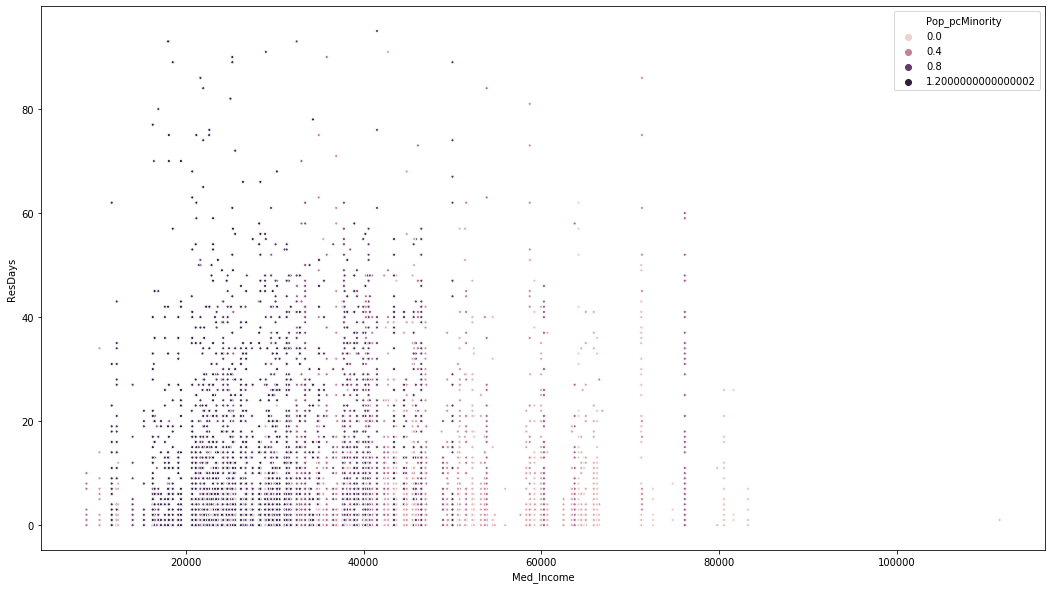

In [71]:
fig, ax = plt.subplots(figsize=(18,10))

sns.scatterplot('Med_Income','ResDays',data=ph13full_df,
                marker='.',
                hue='Pop_pcMinority')

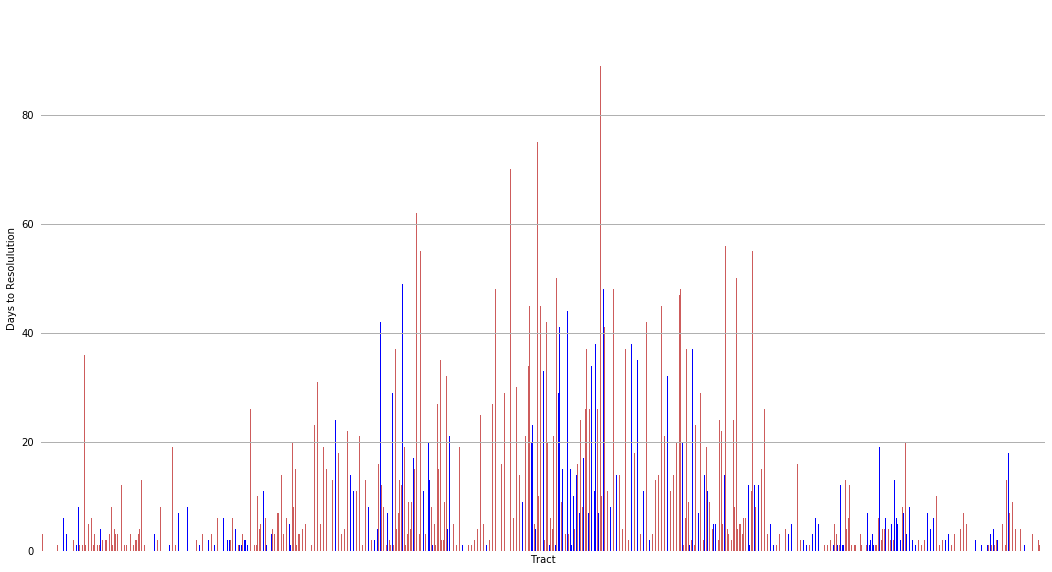

In [70]:
def build_colors(row):
    if row['Pop_pcMinority'] >= 0.51:
        return 'indianred'
    else:
        return 'blue'
colors = ph13full_df.reset_index().apply(build_colors, axis=1)

ax = ph13full_df.plot(x='Tract', y='ResDays', kind='bar', color=colors, legend=None, figsize=(18,10))
ax.yaxis.grid(linewidth=1)
# ax.set_title("Minority Districts See longer Waits", fontname='Franklin Gothic Medium', fontsize=18)
ax.yaxis.set_label_text("Days to Resolulution")
plt.tick_params(left=False, bottom=False, labelbottom=False)
plt.box(False)

# Linear regression

Using the `statsmodels` package, run a linear regression to find the coefficient relating percent minority and pothole fill times.

In [60]:
mod = sm.OLS(ph13full_df.Pop_pcMinority, ph13full_df.ResDays)
res = mod.fit()

In [61]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         Pop_pcMinority   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Tue, 16 Jul 2019   Prob (F-statistic):                         nan
Time:                        03:13:31   Log-Likelihood:                             nan
No. Observations:                8707   AIC:                                        nan
Df Residuals:                    8706   BIC:                                        nan
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ResDays           nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Translate that into the form **"every X percentage point change in the minority population translates to a Y change in pot hole fill times"**

Do you feel comfortable that someone can understand that? Can you reword it to make it more easily understandable?

# Other methods of explanation

While the regression is technically correct, it just does't sound very nice. What other options do we have?

## What's the average wait to fill a pothole between majority-white and majority-minority census tracts?

You'll need to create a new column to specify whether the census tract is majority White or not.

In [ ]:
ph13full_df['Pop_pcMinority'] = ph13full_df.Pop_pcMinority

## How does the average wait time to fill a pothole change as more minorities live in an area?

* **Tip:** Use `.cut` or `.qcut` to split the percent minority (or white) into a few different bins.

# Bonus: Income

`R12216226_SL140.csv` contains income data for each census tract in Wisconsin. Add it into your analysis.

If you run a multivariate regression also including income, how does this change things?